HSC query: https://hsc-release.mtk.nao.ac.jp/datasearch/catalog_jobs

```
SELECT 
        object_id 
      , ra 
      , dec 
      , g_cmodel_mag as mag_g
      , g_cmodel_magsigma as mag_g_err
      , r_cmodel_mag as mag_r
      , r_cmodel_magsigma as mag_r_err
      , r_extendedness_value
      , i_extendedness_value
    FROM 
        pdr2_wide.forced 
    WHERE
		isprimary 
        AND r_cmodel_mag < 25.5
		AND (ra > 175) AND (ra < 195)
		AND (dec > -2.2) AND (dec < 1.8)
        AND NOT g_pixelflags_edge 
        AND NOT r_pixelflags_edge 
        AND NOT g_pixelflags_interpolatedcenter 
        AND NOT r_pixelflags_interpolatedcenter 
        AND NOT g_pixelflags_saturatedcenter 
        AND NOT r_pixelflags_saturatedcenter 
        AND NOT g_pixelflags_crcenter 
        AND NOT r_pixelflags_crcenter 
        AND NOT g_pixelflags_bad 
        AND NOT r_pixelflags_bad 
        AND NOT g_cmodel_flag 
        AND NOT r_cmodel_flag 
;
```

In [2]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import binned_statistic
from tqdm import tqdm

In [3]:
decals = at.Table.read('../decals_hsc_compare.fits.gz')

# from: https://datalab.noao.edu/docs/manual/Appendices/ExampleQueries/ExampleQueries.html
star_mask = ((decals['type'] == 'PSF') &
             (decals['brick_primary'] == 1) &
             (decals['allmask_g'] == 0) & 
             (decals['allmask_r'] == 0) &
             (decals['fracflux_g'] < 0.05) &
             (decals['fracflux_r'] < 0.05))
decals = decals[star_mask]
decals = decals[decals['ra']< 189]

# decals = decals[(decals['dchisq_1'] > 1e3)]
# decals = decals[decals['type'] == 'PSF']
decals_c = coord.SkyCoord(decals['ra'], decals['dec'], unit=u.deg)

In [4]:
hsc = at.Table.read('../hsc_decals_compare.fits')
hsc = hsc[hsc['ra']< 189]
hsc_c = coord.SkyCoord(hsc['ra'], hsc['dec'], unit=u.deg)

In [53]:
ps1 = at.Table.read('../sdss_compare.fits.gz')
ps1 = ps1[ps1['ra']< 189]
ps1_c = coord.SkyCoord(ps1['ra'], ps1['dec'], unit=u.deg)

In [6]:
gaia = at.Table.read('../gaia_compare.fits.gz')
gaia = gaia[gaia['ra']<189]
gaia = gaia[gaia['phot_g_mean_mag'] < 12.5]

In [7]:
gaia_c = coord.SkyCoord(gaia['ra'], gaia['dec'], unit=u.deg)
len(gaia_c)

1937

In [9]:
len(decals), len(hsc), len(ps1), len(gaia)

(1149249, 11791508, 1613466, 1937)

### Compare sky area:

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


(-1, 0)

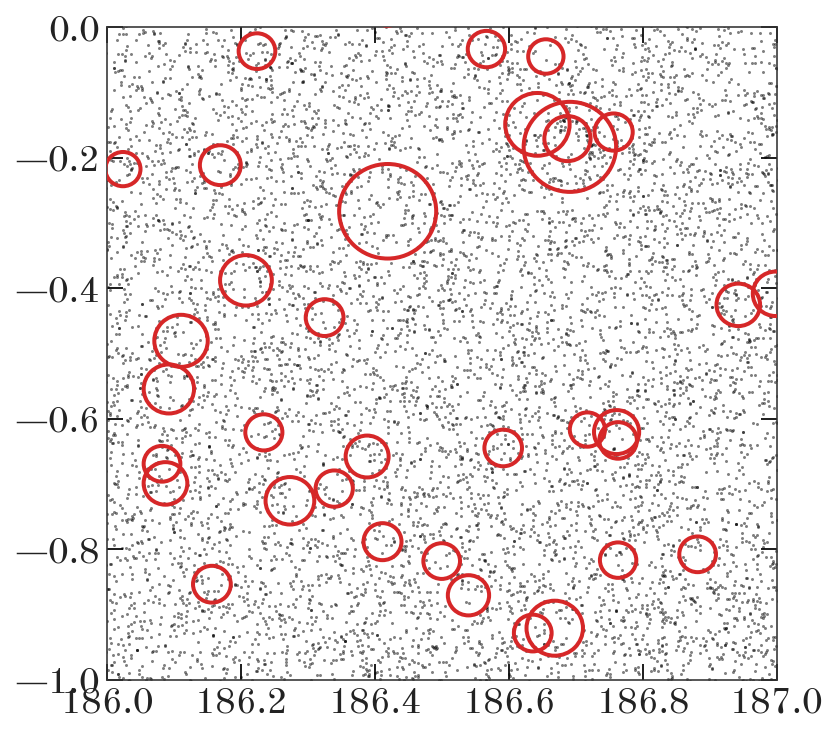

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

derp = hsc_c[(hsc['mag_g'] > 20) & (hsc['mag_g'] < 25) & 
             (hsc['r_extendedness_value'] == 0)]
ax.plot(derp.ra.degree,
        derp.dec.degree,
        marker='o', ls='none', ms=1.5, mew=0, alpha=0.5)

for row, ccc in zip(gaia, gaia_c):
    if ccc.ra.degree < 186 or ccc.ra.degree > 187: continue
    circ_rad = (5*u.arcmin * (7 / row['phot_g_mean_mag'])**2).to_value(u.degree)
    circ = mpl.patches.Circle((ccc.ra.degree, ccc.dec.degree),
                              radius=circ_rad, zorder=100, linewidth=2,
                              facecolor='none', edgecolor='tab:red')
    ax.add_patch(circ)
    
ax.set_xlim(186, 187)
ax.set_ylim(-1, 0)

In [12]:
hsc_ext_col = 'i_extendedness_value'

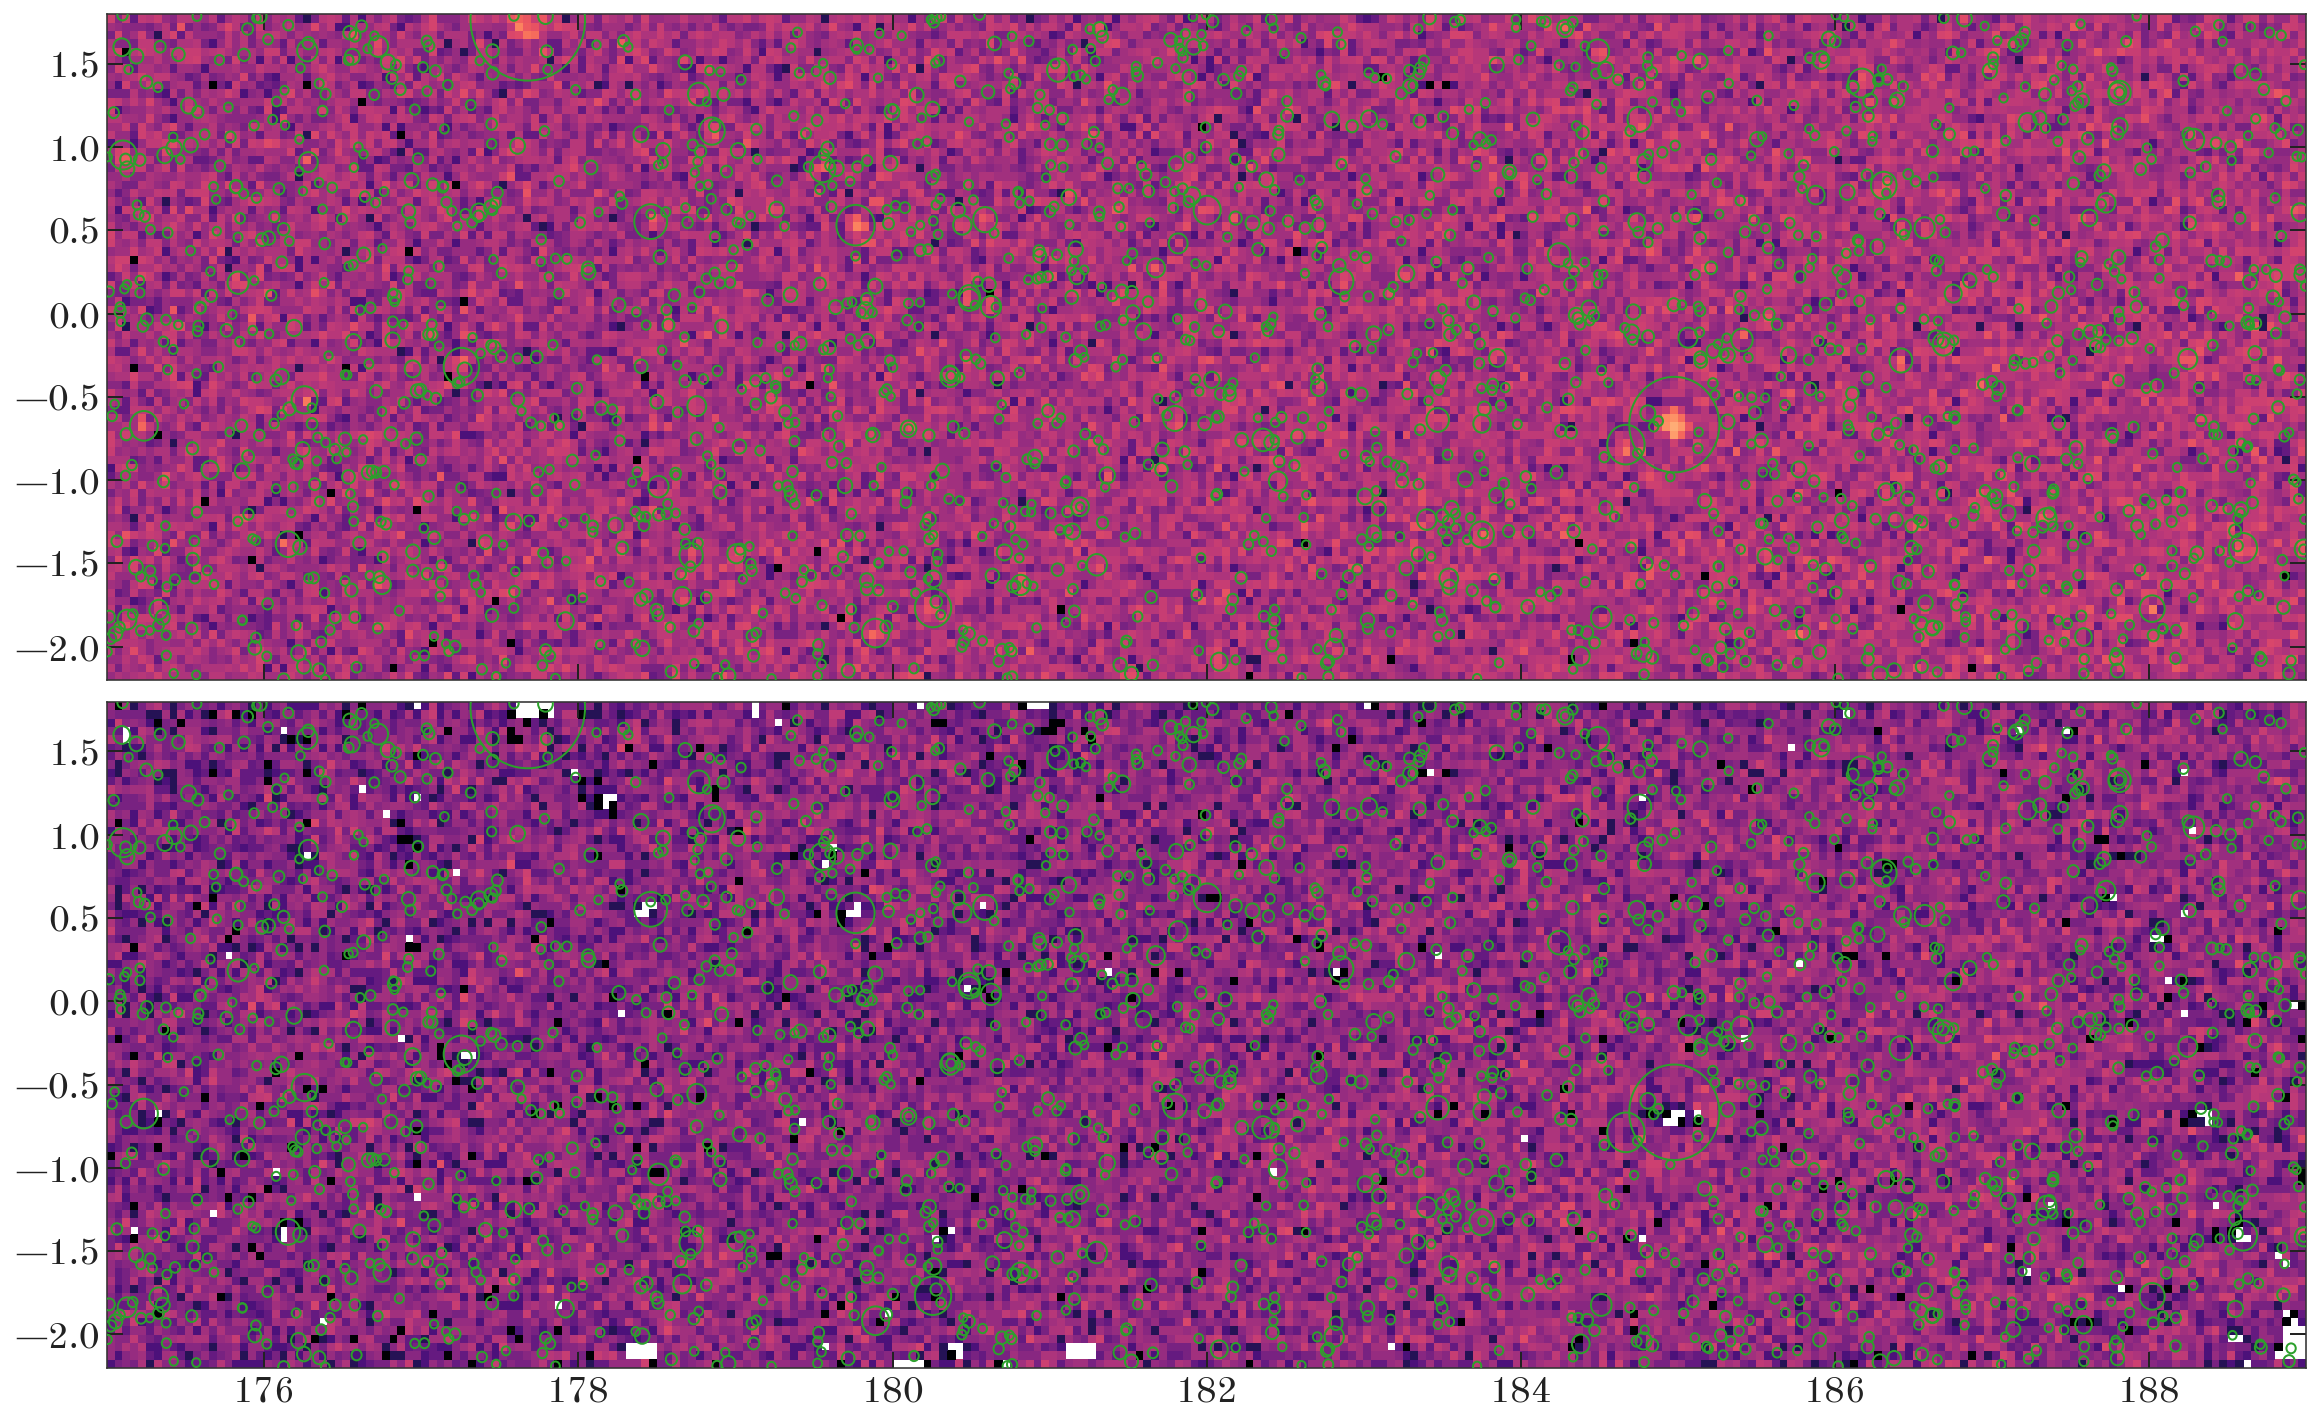

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10), 
                         sharex=True, sharey=True)

sky_bins = (np.arange(175, 189+1e-3, 0.05),
            np.arange(-2.2, 1.8+1e-3, 0.05))

mag_lim = (19, 22.8)

ax = axes[0]
ax.hist2d(decals['ra'][(decals['mag_g']>mag_lim[0]) & (decals['mag_g']<mag_lim[1])], 
          decals['dec'][(decals['mag_g']>mag_lim[0]) & (decals['mag_g']<mag_lim[1])],
          bins=sky_bins, norm=mpl.colors.LogNorm(vmin=1, vmax=1e2));

ax = axes[1]
ax.hist2d(hsc['ra'][(hsc[hsc_ext_col] == 0.) & 
                    (hsc['mag_g']>mag_lim[0]) & 
                    (hsc['mag_g']<mag_lim[1])],
          hsc['dec'][(hsc[hsc_ext_col] == 0.) & 
                     (hsc['mag_g']>mag_lim[0]) & 
                     (hsc['mag_g']<mag_lim[1])],
          bins=sky_bins, norm=mpl.colors.LogNorm(vmin=1, vmax=1e2));

for ax in axes:
    bright_rads = []
    for row, ccc in zip(gaia, gaia_c):
        circ_rad = (5*u.arcmin * (7 / row['phot_g_mean_mag'])**2).to_value(u.degree)
        bright_rads.append(circ_rad)
        circ = mpl.patches.Circle((ccc.ra.degree, ccc.dec.degree),
                                  radius=circ_rad, zorder=100,
                                  facecolor='none', edgecolor='tab:green')
        ax.add_patch(circ)
    bright_rads = bright_rads * u.deg

fig.tight_layout()

In [14]:
from schwimmbad import MultiPool

In [15]:
# hsc_mask = []
# dec_mask = []
# for sep, ccc in tqdm(zip(bright_rads, gaia_c), total=len(gaia_c)):
#     hsc_mask.append(np.where(hsc_c.separation(ccc) < sep)[0])
#     dec_mask.append(np.where(decals_c.separation(ccc) < sep)[0])
# hsc_mask = np.unique(np.concatenate(hsc_mask))
# dec_mask = np.unique(np.concatenate(dec_mask))
# len(hsc_mask), len(dec_mask)

def worker(task):
    sep, ccc = task
    return (np.where(hsc_c.separation(ccc) < sep)[0],
            np.where(decals_c.separation(ccc) < sep)[0],
            np.where(ps1_c.separation(ccc) < sep)[0])

tasks = list(zip(bright_rads, gaia_c))
with MultiPool() as pool:
    hsc_mask = []
    dec_mask = []
    ps1_mask = []
    
    for m1, m2, m3 in pool.map(worker, tasks):
        hsc_mask.append(m1)
        dec_mask.append(m2)
        ps1_mask.append(m3)
        
hsc_mask = np.unique(np.concatenate(hsc_mask))
dec_mask = np.unique(np.concatenate(dec_mask))
ps1_mask = np.unique(np.concatenate(ps1_mask))

In [55]:
masked_hsc = hsc.copy()
masked_hsc.remove_rows(hsc_mask)

masked_dec = decals.copy()
masked_dec.remove_rows(dec_mask)

masked_ps1 = ps1.copy()
masked_ps1.remove_rows(ps1_mask)

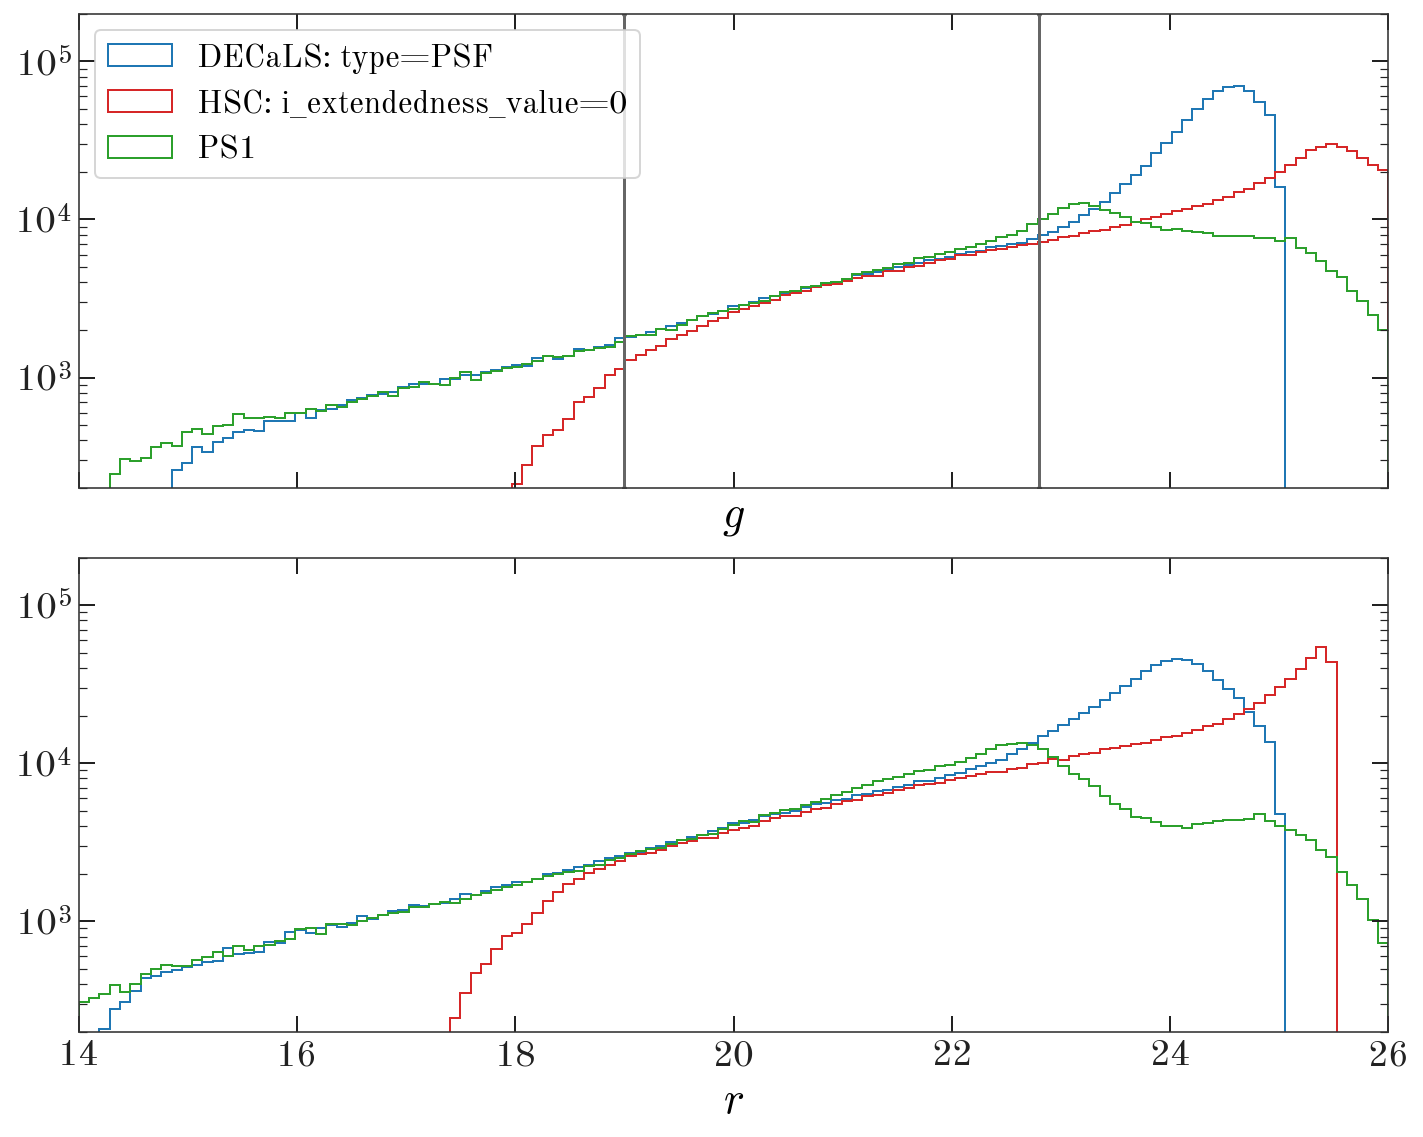

In [57]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), 
                         sharex=True, sharey=True)

bins = np.linspace(14, 26, 128)

ax = axes[0]
ax.hist(masked_dec['mag_g'], bins=bins, 
        histtype='step', color='tab:blue',
        label='DECaLS: type=PSF')
ax.hist(masked_hsc['mag_g'][masked_hsc[hsc_ext_col] != 1.], 
        bins=bins, histtype='step', color='tab:red',
        label=f'HSC: {hsc_ext_col}=0')
ax.hist(masked_ps1['g'], 
        bins=bins, histtype='step', color='tab:green',
        label=f'PS1')

ax.set_xlabel('$g$')
ax.set_yscale('log')
ax.axvline(19)
ax.axvline(22.8)
ax.legend(loc='upper left', fontsize=16)

ax = axes[1]
ax.hist(masked_dec['mag_r'], bins=bins, histtype='step', color='tab:blue')
ax.hist(masked_hsc['mag_r'][masked_hsc[hsc_ext_col] != 1.], 
        bins=bins, histtype='step', color='tab:red')
ax.hist(masked_ps1['r'], 
        bins=bins, histtype='step', color='tab:green',
        label=f'PS1')
ax.set_xlabel('$r$')
ax.set_xlim(14, 26)
ax.set_yscale('log')
ax.set_ylim(2e2, 2e5)

fig.tight_layout()
# fig.savefig('hsc_decals_gr_dist.png', dpi=250)

Make the DECaLS version of Fig. 1 from Shipp+2018

In [58]:
mag_lim = (20, 25)

dec_mag_mask = (masked_dec['mag_g'] > mag_lim[0]) & (masked_dec['mag_g'] < mag_lim[1])
dec_mag = masked_dec[dec_mag_mask]
decals_mag_c = coord.SkyCoord(masked_dec[dec_mag_mask]['ra'], 
                              masked_dec[dec_mag_mask]['dec'], 
                              unit=u.deg)

hsc_mag_mask = (masked_hsc['mag_g'] > mag_lim[0]) & (masked_hsc['mag_g'] < mag_lim[1])
hsc_mag = masked_hsc[hsc_mag_mask]
hsc_mag_c = coord.SkyCoord(masked_hsc[hsc_mag_mask]['ra'], 
                           masked_hsc[hsc_mag_mask]['dec'], 
                           unit=u.deg)

ps1_mag_mask = (masked_ps1['g'] > mag_lim[0]) & (masked_ps1['g'] < mag_lim[1])
ps1_mag = masked_ps1[ps1_mag_mask]
ps1_mag_c = coord.SkyCoord(ps1_mag['ra'], 
                           ps1_mag['dec'], 
                           unit=u.deg)

/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/apricewhelan/anaconda/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [33]:
idx, sep, _ = decals_mag_c.match_to_catalog_sky(hsc_mag_c)

In [34]:
len(masked_dec), len(dec_mag_mask)

(979232, 979232)

In [35]:
matched_dec = dec_mag[sep < 1*u.arcsec]
matched_hsc = hsc_mag[idx[sep < 1*u.arcsec]]

In [65]:
ps1_idx, ps1_sep, _ = ps1_mag_c.match_to_catalog_sky(hsc_mag_c[hsc_mag['i_extendedness_value'] == 1])
matched_ps1 = ps1_mag[ps1_sep < 1*u.arcsec]

Now for completeness of point sources:

In [37]:
hsc_pt_src = (hsc_mag[hsc_ext_col] == 0)
idx2, sep2, _ = hsc_mag_c[hsc_pt_src].match_to_catalog_sky(decals_c)

In [38]:
hsc_in_decals = np.zeros(hsc_pt_src.sum()).astype(bool)
hsc_in_decals[sep2 < 2*u.arcsec] = True
hsc_in_decals.sum()

256218

In [68]:
ps1_idx2, ps1_sep2, _ = hsc_mag_c[hsc_pt_src].match_to_catalog_sky(ps1_c)
hsc_in_ps1 = np.zeros(hsc_pt_src.sum()).astype(bool)
hsc_in_ps1[ps1_sep2 < 2*u.arcsec] = True
hsc_in_ps1.sum()

183883

In [39]:
mag_bins = np.linspace(mag_lim[0], mag_lim[1], 32)
mag_bin_ctr = 0.5 * (mag_bins[:-1] + mag_bins[1:])

In [69]:
hsc_stat = binned_statistic(hsc_mag[hsc_pt_src]['mag_g'], 
                            hsc_in_decals,
                            bins=mag_bins,
                            statistic=lambda x: np.nansum(x)/len(x))

ps1_hsc_stat = binned_statistic(hsc_mag[hsc_pt_src]['mag_g'], 
                                hsc_in_ps1,
                                bins=mag_bins,
                                statistic=lambda x: np.nansum(x)/len(x))

In [66]:
Hps1, _ = np.histogram(ps1['g'], bins=mag_bins)
Hps1_hsc, _ = np.histogram(matched_ps1['g'], bins=mag_bins)

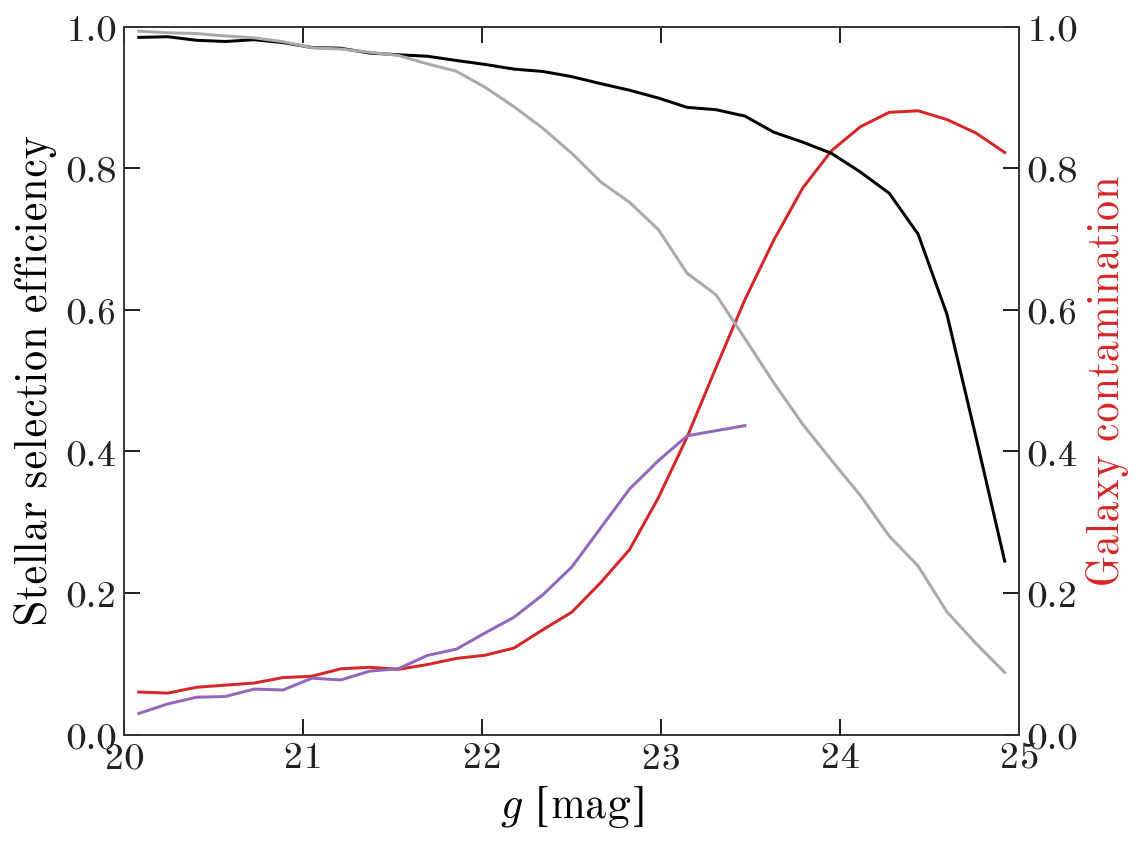

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

hsc_gal_stat = binned_statistic(matched_hsc['mag_g'], 
                                matched_hsc[hsc_ext_col],
                                bins=mag_bins,
                                statistic=lambda x: np.nansum(x)/len(x))
plt.plot(mag_bin_ctr, hsc_gal_stat.statistic, 
         color='tab:red', marker='')

plt.plot(mag_bin_ctr[mag_bin_ctr < 23.5], 
         (Hps1_hsc / Hps1)[mag_bin_ctr < 23.5], 
         color='tab:purple', marker='')

plt.plot(mag_bin_ctr, hsc_stat.statistic, 
         color='k', marker='')

plt.plot(mag_bin_ctr, ps1_hsc_stat.statistic,
         color='#aaaaaa', marker='')

plt.xlim(20., 25)
plt.ylim(0, 1)

plt.xlabel('$g$ [mag]')
plt.ylabel('Stellar selection efficiency')

ax2 = plt.twinx()
ax2.set_ylim(0, 1)
ax2.set_ylabel('Galaxy contamination', color='tab:red')

fig.tight_layout()

# fig.savefig('contam.png', dpi=250)